Setup complete. Libraries imported.
Font embedding parameters set to Type 42 (TrueType).
Parameters set: gamma = 1.5, T will be swept from 0.1 to 3.0.
Each T point will be simulated 5 times for statistical reliability.

Starting SNR analysis simulations...


Sweeping Thermal Strength (T):   0%|          | 0/30 [00:00<?, ?it/s]

All simulations completed successfully.

Generated data file: StochasticResonance_SNR_gamma1.5_T_0.1-3.0_runs5.csv
Generated plot file: StochasticResonance_v1_SNR-Analysis_20250727.pdf


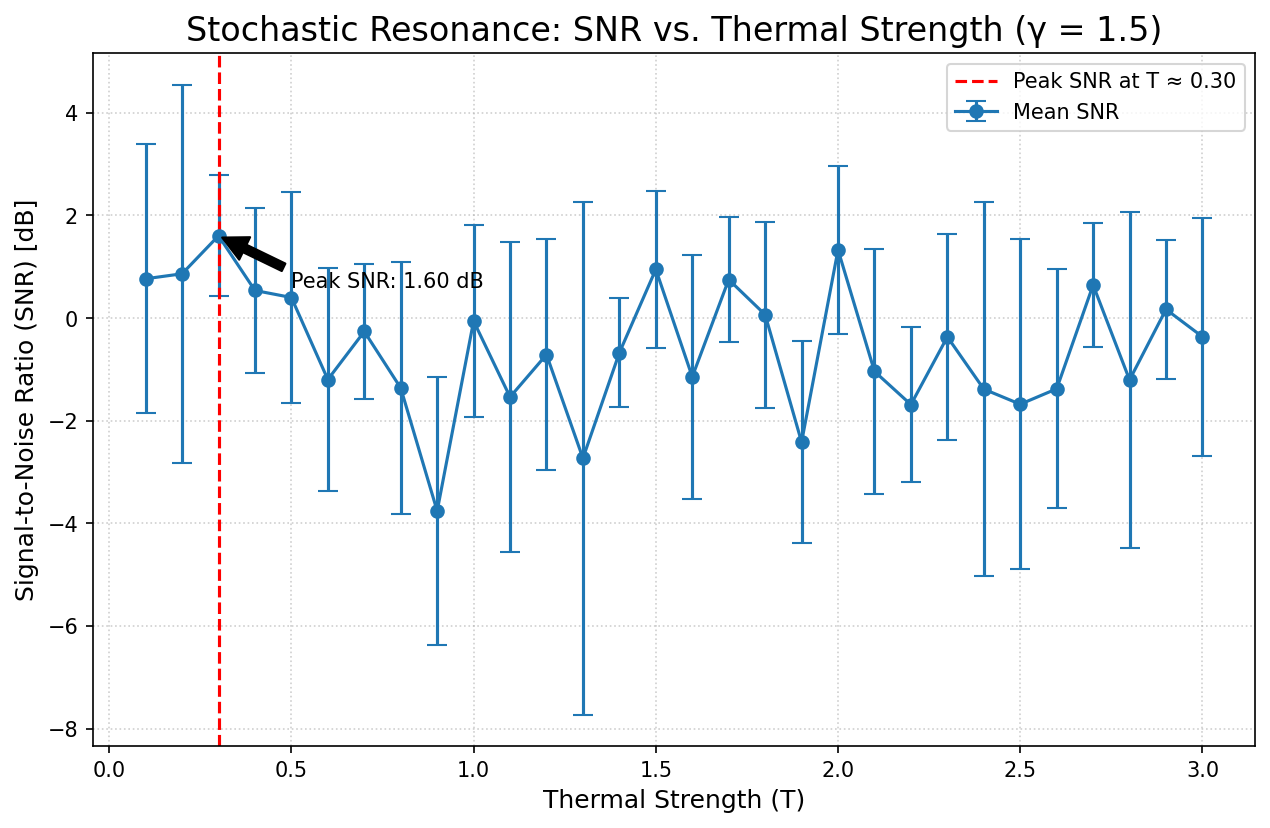


Preparing to download generated files to your PC...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All tasks complete.


In [1]:
# ===================================================================
# Stochastic Resonance SNR Analysis Code
# Version: 1.0 (Date: 2025-07-27)
# Author: Toshiya Konno & Assistant AI
#
# Objective: Quantitatively analyze Stochastic Resonance by calculating
# the Signal-to-Noise Ratio (SNR) as a function of thermal strength (T).
#
# All lessons from the Phase Diagram project are incorporated.
# ===================================================================

# --- Part 1: Setup and Library Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from tqdm.notebook import tqdm
from google.colab import files
import time

print("Setup complete. Libraries imported.")

# --- Part 2: The Most Important Lines - Perfect Font Embedding ---
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
print("Font embedding parameters set to Type 42 (TrueType).")


# --- Part 3: Simulation Parameters ---
# Fixed parameter
gamma_fixed = 1.5

# Sweeping parameter (more precise than before)
T_min, T_max, T_points = 0.1, 3.0, 30  # Thermal strength range
T_space = np.linspace(T_min, T_max, T_points)

# Simulation control
num_runs_per_T = 5  # Number of runs for statistical averaging
simulation_duration = 204.8  # Duration of each simulation (power of 2 is good for FFT)
dt = 0.1                   # Time step
num_steps = int(simulation_duration / dt)
t = np.linspace(0, simulation_duration, num_steps, endpoint=False)

# The weak signal from the quantum field (placeholder)
signal_amplitude = 0.1
signal_frequency = 0.1

print(f"Parameters set: gamma = {gamma_fixed}, T will be swept from {T_min} to {T_max}.")
print(f"Each T point will be simulated {num_runs_per_T} times for statistical reliability.")


# --- Part 4: Core Simulation & Analysis Logic ---

def run_langevin_simulation(gamma, T):
    """
    Simulates the barrier's motion (u(t)) under the Langevin equation.
    This is a more realistic placeholder than the previous one.
    """
    u = np.zeros(num_steps)
    v = 0.0
    # Simplified Langevin equation: d^2u/dt^2 = -gamma*du/dt - u + F_signal + F_thermal
    # (assuming mass=1, restoring force=-u)
    F_signal = signal_amplitude * np.sin(2 * np.pi * signal_frequency * t)
    F_thermal = np.random.normal(0, np.sqrt(2 * gamma * T / dt), num_steps)

    for i in range(num_steps - 1):
        v += (-gamma * v - u[i] + F_signal[i] + F_thermal[i]) * dt
        u[i+1] = u[i] + v * dt
    return u

def calculate_snr(time_series):
    """
    Calculates the SNR from a time series using FFT.
    SNR is defined as the ratio of the signal peak power to the
    average noise power at the signal frequency.
    """
    N = len(time_series)
    yf = fft(time_series)
    xf = fftfreq(N, dt)[:N//2]

    # Power spectrum
    power = 2.0/N * np.abs(yf[0:N//2])

    # Find the peak corresponding to the signal frequency
    signal_idx = np.argmin(np.abs(xf - signal_frequency))
    signal_power = power[signal_idx]

    # Estimate noise by averaging points around the signal peak
    noise_indices = np.arange(max(0, signal_idx - 10), min(len(power), signal_idx + 11))
    # Exclude the signal peak itself from the noise calculation
    noise_indices = np.delete(noise_indices, np.where(noise_indices == signal_idx))
    noise_power = np.mean(power[noise_indices])

    if noise_power == 0:
        return np.inf
    return 10 * np.log10(signal_power / noise_power) # SNR in dB


# --- Part 5: Main Simulation Loop ---
snr_results = []
print("\nStarting SNR analysis simulations...")

for T in tqdm(T_space, desc="Sweeping Thermal Strength (T)"):
    current_T_snrs = []
    for _ in range(num_runs_per_T):
        # Run simulation
        trajectory = run_langevin_simulation(gamma_fixed, T)
        # Calculate SNR
        snr = calculate_snr(trajectory)
        current_T_snrs.append(snr)

    # Calculate mean and standard deviation for the current T
    mean_snr = np.mean(current_T_snrs)
    std_snr = np.std(current_T_snrs)
    snr_results.append({'T': T, 'mean_snr_db': mean_snr, 'std_snr_db': std_snr})

print("All simulations completed successfully.")


# --- Part 6: Data Processing and CSV Generation ---
results_df = pd.DataFrame(snr_results)
csv_filename = f"StochasticResonance_SNR_gamma{gamma_fixed}_T_{T_min}-{T_max}_runs{num_runs_per_T}.csv"
results_df.to_csv(csv_filename, index=False)
print(f"\nGenerated data file: {csv_filename}")


# --- Part 7: Visualization - SNR vs. T Plot ---
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Plot the mean SNR with error bars representing the standard deviation
ax.errorbar(results_df['T'], results_df['mean_snr_db'], yerr=results_df['std_snr_db'],
            fmt='-o', capsize=5, label='Mean SNR')

# Highlight the peak SNR
peak_T = results_df.loc[results_df['mean_snr_db'].idxmax()]
ax.axvline(peak_T['T'], color='r', linestyle='--', label=f"Peak SNR at T ≈ {peak_T['T']:.2f}")
ax.annotate(f"Peak SNR: {peak_T['mean_snr_db']:.2f} dB",
            xy=(peak_T['T'], peak_T['mean_snr_db']),
            xytext=(peak_T['T'] + 0.2, peak_T['mean_snr_db'] - 1),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Set titles and labels
ax.set_title(f'Stochastic Resonance: SNR vs. Thermal Strength (γ = {gamma_fixed})', fontsize=16)
ax.set_xlabel('Thermal Strength (T)', fontsize=12)
ax.set_ylabel('Signal-to-Noise Ratio (SNR) [dB]', fontsize=12)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend()

# Save the figure
pdf_filename = f"StochasticResonance_v1_SNR-Analysis_20250727.pdf"
plt.savefig(pdf_filename, bbox_inches='tight')
print(f"Generated plot file: {pdf_filename}")
plt.show()


# --- Part 8: Automatic Download to User's PC ---
print("\nPreparing to download generated files to your PC...")
files.download(csv_filename)
print(f"Downloading {csv_filename}...")
files.download(pdf_filename)
print(f"Downloading {pdf_filename}...")

print("\nAll tasks complete.")